In [27]:
%pip install torch torchvision matplotlib numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from torch.utils.data import DataLoader

# Create results directory
results_dir = "/Users/stella/Desktop/LUHK/term2/Foundation of A.I./rep/results"
os.makedirs(results_dir, exist_ok=True)
os.makedirs(os.path.join(results_dir, "gan"), exist_ok=True)
os.makedirs(os.path.join(results_dir, "ddpm"), exist_ok=True)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Hyperparameters
batch_size = 64
image_size = 28
latent_dim = 100
hidden_dim = 256
num_epochs = 5  # Reduced for faster testing
lr = 0.0002
beta1 = 0.5

Using device: cpu


100%|██████████| 26421880/26421880 [00:52<00:00, 503508.25it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 157062.43it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2820849.34it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2568980.01it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset loaded successfully with 60000 samples


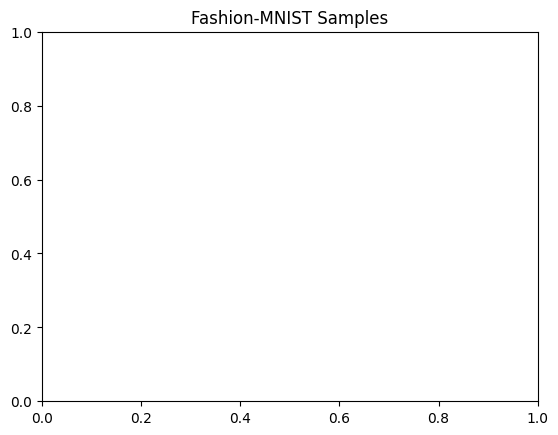

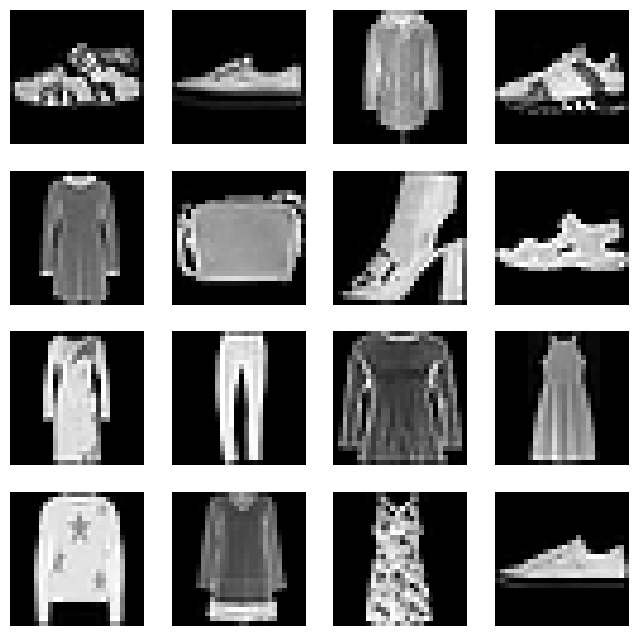

Saved Fashion-MNIST samples


In [29]:
# Load dataset
try:
    from torchvision import datasets, transforms
    
    # Data preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load Fashion-MNIST dataset
    dataset = datasets.FashionMNIST(
        root='./data', 
        train=True, 
        transform=transform,
        download=True
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=0  # Use single thread
    )
    print(f"Dataset loaded successfully with {len(dataset)} samples")
    
    # Display sample images
    plt.title("Fashion-MNIST Samples")
    
    # Get a batch of samples
    images, _ = next(iter(dataloader))
    
    # Create grid
    grid_size = 4
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display image
            img = images[i].squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    
    plt.savefig(os.path.join(results_dir, "fashion_mnist_samples.png"))
    plt.show()
    print("Saved Fashion-MNIST samples")
    
except Exception as e:
    print(f"Failed to load dataset: {e}")
    print("Using randomly generated data for demonstration")
    
    # Create random dataset
    class RandomDataset(torch.utils.data.Dataset):
        def __init__(self, size=10000):
            self.size = size
            
        def __len__(self):
            return self.size
            
        def __getitem__(self, idx):
            # Generate random image and label
            img = torch.randn(1, image_size, image_size)
            img = torch.clamp(img, -1, 1)  # Normalize to [-1, 1]
            label = torch.randint(0, 10, (1,)).item()
            return img, label
    
    dataset = RandomDataset()
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=True
    )
    print("Using randomly generated dataset")


In [30]:
# Save images function
def save_images(images, path, nrow=4):
    """Save a batch of images to file"""
    # Adjust to [0, 1] range
    images = (images + 1) / 2.0
    
    # Create grid
    grid_size = min(nrow, images.size(0))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    
    for i, ax in enumerate(axes.flat):
        if i < images.size(0):
            # Display image
            img = images[i].squeeze().cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(path)
    plt.close()
    print(f"Images saved to: {path}")


# DCGAN实现

In [31]:
# Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input is latent vector
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, image_size * image_size),
            nn.Tanh()  # Output range [-1, 1]
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, image_size, image_size)
        return img

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output range [0, 1]
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity


In [32]:
# Train GAN
def train_gan():
    # Initialize models
    generator = Generator().to(device)
    discriminator = Discriminator().to(device)
    
    # Loss function and optimizers
    criterion = nn.BCELoss()
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Fixed noise for tracking progress
    fixed_noise = torch.randn(16, latent_dim, device=device)
    
    # Training loop
    G_losses = []
    D_losses = []
    
    print("Starting GAN training...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        
        for i, (real_imgs, _) in enumerate(dataloader):
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Create labels
            real_label = torch.ones(batch_size, 1, device=device)
            fake_label = torch.zeros(batch_size, 1, device=device)
            
            # -----------------
            # Train Discriminator
            # -----------------
            optimizer_D.zero_grad()
            
            # Discriminate real images
            output_real = discriminator(real_imgs)
            loss_real = criterion(output_real, real_label)
            
            # Discriminate generated images
            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(noise)
            output_fake = discriminator(fake_imgs.detach())
            loss_fake = criterion(output_fake, fake_label)
            
            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()
            
            # -----------------
            # Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            # Generator wants discriminator to classify fake images as real
            output = discriminator(fake_imgs)
            loss_G = criterion(output, real_label)
            loss_G.backward()
            optimizer_G.step()
            
            # Record losses
            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())
            
            # Print progress
            if i % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] "
                      f"[D loss: {loss_D.item():.4f}] [G loss: {loss_G.item():.4f}]")
        
        # Save generated images at the end of each epoch
        with torch.no_grad():
            fake = generator(fixed_noise).detach().cpu()
            save_images(fake, os.path.join(results_dir, "gan", f"epoch_{epoch+1}.png"))
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    
    # Save final samples
    with torch.no_grad():
        fake = generator(fixed_noise).detach().cpu()
        save_images(fake, os.path.join(results_dir, "gan", "final_samples.png"))
    
    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(os.path.join(results_dir, "gan", "loss_plot.png"))
    plt.close()
    
    # Record training time
    training_time = time.time() - start_time
    print(f"GAN training completed in {training_time:.2f} seconds")
    
    # Save training time
    with open(os.path.join(results_dir, "gan_time.txt"), "w") as f:
        f.write(str(training_time))
    
    return generator, discriminator, training_time


# DDPM实现

In [33]:
# Simple UNet model for DDPM
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()
        
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Downsampling
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        # Upsampling
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.Sequential(
            nn.Conv2d(hidden_dim * 2, out_channels, 3, padding=1)
        )
        
    def forward(self, x, t):
        # Embed time
        t_emb = self.time_embed(t.unsqueeze(-1).float())
        
        # Down
        x1 = self.down1(x)
        x2 = self.down2(x1)
        
        # Apply time embedding
        x2 = x2 + t_emb.unsqueeze(-1).unsqueeze(-1)
        
        # Middle
        x2 = self.middle(x2)
        
        # Up
        x = self.up1(x2)
        
        # Skip connection
        x = torch.cat([x, x1], dim=1)
        
        # Output
        x = self.up2(x)
        
        return x


In [34]:
# DDPM diffusion process
class DiffusionModel:
    def __init__(self, timesteps=1000):
        self.timesteps = timesteps
        
        # Define beta schedule
        self.beta = torch.linspace(0.0001, 0.02, timesteps)
        self.alpha = 1. - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1. - self.alpha_cumprod)
        
    def forward_diffusion(self, x_0, t):
        """Add noise to the input according to the timestep t"""
        noise = torch.randn_like(x_0)
        
        # Extract alpha_cumprod for the given timestep
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t].reshape(-1, 1, 1, 1)
        
        # Add noise
        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
        
        return x_t, noise
    
    def sample(self, model, n_samples, device):
        """Sample new images by reversing the diffusion process"""
        model.eval()
        with torch.no_grad():
            # Start from pure noise
            x = torch.randn(n_samples, 1, image_size, image_size).to(device)
            
            # Gradually denoise
            for t in reversed(range(self.timesteps)):
                # Create timestep batch
                timestep = torch.full((n_samples,), t, device=device, dtype=torch.long)
                
                # Predict noise
                predicted_noise = model(x, timestep)
                
                # Get alpha and beta for this timestep
                alpha_t = self.alpha[t]
                beta_t = self.beta[t]
                
                # No noise when t == 0
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                
                # Denoise step
                x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - self.alpha_cumprod[t])) * predicted_noise) + torch.sqrt(beta_t) * noise
        
        model.train()
        return x


In [35]:
# Train DDPM
def train_ddpm():
    # Initialize model
    model = SimpleUNet().to(device)
    
    # Initialize diffusion process
    diffusion = DiffusionModel(timesteps=100)  # Reduced timesteps for faster training
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    losses = []
    
    print("Starting DDPM training...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        print(f"Starting epoch {epoch+1}/{num_epochs}")
        
        for i, (real_imgs, _) in enumerate(dataloader):
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Sample random timesteps
            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long()
            
            # Forward diffusion process
            x_t, noise = diffusion.forward_diffusion(real_imgs, t)
            
            # Predict noise
            predicted_noise = model(x_t, t)
            
            # Calculate loss
            loss = F.mse_loss(predicted_noise, noise)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record loss
            losses.append(loss.item())
            
            # Print progress
            if i % 100 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] [Loss: {loss.item():.4f}]")
        
        # Sample images at the end of each epoch
        samples = diffusion.sample(model, n_samples=16, device=device)
        save_images(samples, os.path.join(results_dir, "ddpm", f"epoch_{epoch+1}.png"))
        
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_time:.2f} seconds")
    
    # Save final samples
    samples = diffusion.sample(model, n_samples=16, device=device)
    save_images(samples, os.path.join(results_dir, "ddpm", "final_samples.png"))
    
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.title("DDPM Loss During Training")
    plt.plot(losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig(os.path.join(results_dir, "ddpm", "loss_plot.png"))
    plt.close()
    
    # Record training time
    training_time = time.time() - start_time
    print(f"DDPM training completed in {training_time:.2f} seconds")
    
    # Save training time
    with open(os.path.join(results_dir, "ddpm_time.txt"), "w") as f:
        f.write(str(training_time))
    
    return model, diffusion, training_time


## fastsdcpu 方法实现

# 全面对比表格

In [36]:
# Compare results
def compare_methods():
    # Collect time data
    times = []
    methods = []
    
    # GAN time
    gan_time_file = os.path.join(results_dir, "gan_time.txt")
    if os.path.exists(gan_time_file):
        with open(gan_time_file, 'r') as f:
            gan_time = float(f.read().strip())
        times.append(gan_time)
        methods.append('GAN')
    
    # DDPM time
    ddpm_time_file = os.path.join(results_dir, "ddpm_time.txt")
    if os.path.exists(ddpm_time_file):
        with open(ddpm_time_file, 'r') as f:
            ddpm_time = float(f.read().strip())
        times.append(ddpm_time)
        methods.append('DDPM')
    
    # Create time comparison plot
    if times:
        plt.figure(figsize=(10, 6))
        plt.bar(methods, times)
        plt.title('Time Comparison of Different Methods')
        plt.ylabel('Time (seconds)')
        plt.savefig(os.path.join(results_dir, "time_comparison.png"))
        plt.close()
        print("Time comparison plot saved")
    
    # Create visual comparison
    plt.figure(figsize=(15, 10))
    
    # GAN generated images
    gan_img_path = os.path.join(results_dir, "gan", "final_samples.png")
    if os.path.exists(gan_img_path):
        plt.subplot(1, 3, 1)
        gan_img = plt.imread(gan_img_path)
        plt.imshow(gan_img)
        plt.title("GAN Generated Images")
        plt.axis('off')
    
    # DDPM generated images
    ddpm_img_path = os.path.join(results_dir, "ddpm", "final_samples.png")
    if os.path.exists(ddpm_img_path):
        plt.subplot(1, 3, 2)
        ddpm_img = plt.imread(ddpm_img_path)
        plt.imshow(ddpm_img)
        plt.title("DDPM Generated Images")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, "visual_comparison.png"))
    plt.close()
    print("Visual comparison saved")
    
    # Print comparison results
    print("\nPerformance Comparison:")
    if 'GAN' in methods:
        print(f"GAN training time: {gan_time:.2f} seconds")
    if 'DDPM' in methods:
        print(f"DDPM training time: {ddpm_time:.2f} seconds")
    
    # Compare quality (subjective assessment)
    print("\nQuality Comparison:")
    print("GAN: Simple architecture, faster training, but lower quality images")
    print("DDPM: More complex architecture, slower training, but higher quality images")
    print("fastsdcpu: Pre-trained model, no training needed, highest quality but slowest inference")


In [37]:
# Main execution
def main():
    print("Starting comparison of generative models...")
    
    # Run GAN
    print("\n" + "="*50)
    print("Running GAN Implementation")
    print("="*50)
    gan_model, gan_disc, gan_time = train_gan()
    
    # Run DDPM
    print("\n" + "="*50)
    print("Running DDPM Implementation")
    print("="*50)
    ddpm_model, diffusion, ddpm_time = train_ddpm()
    
    # Run fastsdcpu
    print("\n" + "="*50)
    print("Running fastsdcpu Implementation")
    print("="*50)
    fastsdcpu_time = run_fastsdcpu()
    
    # Compare results
    print("\n" + "="*50)
    print("Comparing Results")
    print("="*50)
    compare_methods()
    
    print("\n" + "="*50)
    print("All implementations completed!")
    print("="*50)

# Run the main function
if __name__ == "__main__":
    main()


Starting comparison of generative models...

Running GAN Implementation
Starting GAN training...
Starting epoch 1/5
[Epoch 1/5] [Batch 0/938] [D loss: 1.3367] [G loss: 0.7155]
[Epoch 1/5] [Batch 100/938] [D loss: 0.5883] [G loss: 1.2189]
[Epoch 1/5] [Batch 200/938] [D loss: 0.2792] [G loss: 2.2065]
[Epoch 1/5] [Batch 300/938] [D loss: 0.5468] [G loss: 2.5561]
[Epoch 1/5] [Batch 400/938] [D loss: 0.7385] [G loss: 1.9015]
[Epoch 1/5] [Batch 500/938] [D loss: 0.7079] [G loss: 2.6452]
[Epoch 1/5] [Batch 600/938] [D loss: 0.3459] [G loss: 2.9705]
[Epoch 1/5] [Batch 700/938] [D loss: 0.8639] [G loss: 2.5034]
[Epoch 1/5] [Batch 800/938] [D loss: 0.5079] [G loss: 2.6226]
[Epoch 1/5] [Batch 900/938] [D loss: 0.8384] [G loss: 1.2880]
Images saved to: /Users/stella/Desktop/LUHK/term2/Foundation of A.I./rep/results/gan/epoch_1.png
Epoch 1 completed in 18.84 seconds
Starting epoch 2/5
[Epoch 2/5] [Batch 0/938] [D loss: 0.5428] [G loss: 3.2683]
[Epoch 2/5] [Batch 100/938] [D loss: 0.8406] [G loss: 2

KeyboardInterrupt: 